In [ ]:
pip install simpy

# 56路线修改后

In [ ]:
import simpy
import numpy as np
import pandas as pd
from collections import deque

# 模拟参数
BUS_CAPACITY = 86

BUS_SPEED = 50  # km/h
NUM_SIMULATIONS = 1000  # Number of simulations to run
headway = 20 #发车间隔

# Route 56: Tuen Mun to Sheung Shui (11 stops, 10 segments)
route_56_forward = {
    'stops': 11,
    'segment_distances': [0.08, 0.5, 0.75, 0.9, 0.4, 0.8, 23.3, 0.55, 0.158, 0.46],  # km
    'segment_times_params': [  # 每个路段的均值、标准差、最小值、最大值
        {'mean': 0.5, 'std': 0.83, 'min': 1, 'max': 3},   # 路段1
        {'mean': 2.67, 'std': 0.816, 'min': 1, 'max': 4},    # 路段2
        {'mean': 3.0, 'std': 0.0, 'min': 3, 'max': 3},    # 路段3
        {'mean': 2.5, 'std': 0.837, 'min': 2, 'max': 4},    # 路段4
        {'mean': 2.0, 'std': 0.632, 'min': 1, 'max': 4}, # 路段5
        {'mean': 2.0, 'std': 0.63, 'min': 1, 'max': 3},    # 路段6
        {'mean': 24, 'std': 1.0, 'min': 22, 'max': 29},   # 路段7
        {'mean': 3.667, 'std': 0.516, 'min': 3, 'max': 5},    # 路段8
        {'mean': 2.167, 'std': 0.753, 'min': 1, 'max': 3},    # 路段9
        {'mean': 2.167, 'std': 0.5, 'min': 1, 'max': 4}],   # 路段10
    'stop_lambdas': [0.5, 0.25, 0.2, 0.15, 0.2, 0.2, 0, 0.3, 0, 0, 0],  # passengers/min per stop
    'alight_probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.68, 0.15, 0.15, 1.0],
    'departures': [550, 570, 590, 610, 630]  # 9:10, 9:30, 9:50, 10:10, 10:30 (mins from midnight)
}
# Route 56: Sheung Shui to Tuen Mun (12 stops, 11 segments)
route_56_backward = {
    'stops': 12,
    'segment_distances': [0.4, 0.3, 0.3, 0.8, 22.4, 0.6, 0.47, 0.2, 0.78, 0.86, 0.65],  # km
    'segment_times_params': [  # 每个路段的均值、标准差、最小值、最大值
        {'mean': 1.714, 'std': 0.448, 'min': 1, 'max': 3},   # 路段1
        {'mean': 2.143, 'std': 0.69, 'min': 1, 'max': 4},    # 路段2
        {'mean': 2.0, 'std': 0.617, 'min': 1, 'max': 4},    # 路段3
        {'mean': 4.286, 'std': 0.756, 'min': 3, 'max': 6},    # 路段4
        {'mean': 24.714, 'std': 1.112, 'min': 23, 'max': 28}, # 路段5
        {'mean': 1.0, 'std': 0.0, 'min': 1, 'max': 1},    # 路段6（固定）
        {'mean': 2.286, 'std': 0.756, 'min': 2, 'max': 4},   # 路段7
        {'mean': 0.571, 'std': 0.617, 'min': 1, 'max': 1},    # 路段8（固定）
        {'mean': 4.0, 'std': 0.617, 'min': 3, 'max': 5},    # 路段9
        {'mean': 5.286, 'std': 0.69, 'min': 3, 'max': 7},   # 路段10
        {'mean': 1.714, 'std': 0.488, 'min': 1, 'max': 3}],     # 路段11
    'stop_lambdas': [0.2, 0.1, 0.3, 1, 0, 0, 0.05, 0.1, 0, 0, 0, 0],  # passengers/min per stop
    'alight_probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.15, 0.08, 0.07, 0.27, 0.56, 1],
    'departures': [565, 585, 605, 625]

}
def initialize_globals():
    """Initialize global variables for simulation."""
    global utilization_56, stop_queues, last_service_times
    utilization_56 = deque()
    stop_queues = {
        f"{direction}_{stop}": {'count': 0, 'arrivals': []}
        for direction in ['forward', 'backward']
        for stop in range(1, max(route_56_forward['stops'], route_56_backward['stops']) + 1)
    }
    last_service_times = {
        f"{direction}_{stop}": 0  # 初始时间设为 0，稍后在 bus_trip 中调整
        for direction in ['forward', 'backward']
        for stop in range(1, max(route_56_forward['stops'], route_56_backward['stops']) + 1)
    }
# 'arrivals': []: 这个键值对是一个空列表，用来存储到达这个站的乘客的时间戳。这个列表用来计算乘客的等待时间
# 'count': 0: 这个键值对用来存储当前在这个站等待上车的乘客数量，初始值为 0

def bus_trip(env, bus_id, headway, forward=True, start_time=0):
    """Simulate a single bus trip with queue-based passenger accumulation and wait time tracking."""
    route_data = route_56_forward if forward else route_56_backward
    stops = route_data['stops']
    segment_distances = route_data['segment_distances']

    # segment_time
    segment_times=[]
    for param in route_data['segment_times_params']:
      if param['std'] == 0:
        segment_times.append(param['mean'])
      else:
        # 生成正态分布随机数，四舍五入并限制到范围
        value=round(np.random.normal(param['mean'], param['std']))
        value=max(param['min'],min(param['max'],value))
        segment_times.append(value)

    stop_lambdas = route_data['stop_lambdas']
    alight_probabilities = route_data['alight_probabilities']


    # 使用 env.timeout 等待直到发车时间（start_time）。如果当前仿真时间（env.now）已经超过发车时间，则立即开始
    yield env.timeout(max(0, start_time - env.now))

    # Current passengers on bus
    passengers = 0

    for stop in range(1, stops + 1):
        stop_key = f"{'forward' if forward else 'backward'}_{stop}"
        # 计算 time_interval
        if stop == 1:
          time_interval = headway  # 首站使用 headway
        else:
          # 对于第一班车，非首站 time_interval
          if stop_key not in last_service_times or last_service_times[stop_key] == 0:
              time_interval = headway  # 第一班车非首站
          else:
              time_interval = env.now - last_service_times[stop_key]  # 其他情况使用到达间隔
              if time_interval <= 0:
                raise ValueError(f"Negative time_interval at stop {stop_key}: {time_interval}")

        # 更新 last_service_times
        last_service_times[stop_key] = env.now

        # Alighting
        if stop == stops:
          alighting = passengers
        else:
          prob_alight = alight_probabilities[stop - 1]
          # Each passenger decides to alight based on probability
          alighting = np.random.binomial(passengers, prob_alight)
        passengers -= alighting

        # Boarding
        # time_interval: 计算乘客累积的时间间隔
        lambda_rate = stop_lambdas[stop - 1]
        # 新到站的乘客数量
        new_arrivals = np.random.poisson(lambda_rate * time_interval)
        # 为每个新到达的乘客生成随机到达时间
        arrival_times = np.random.uniform(low=env.now - time_interval, high=env.now, size=new_arrivals)
        # 记录新乘客的到站时间
        stop_queues[stop_key]['arrivals'].extend(arrival_times)
        # 站点排队人数
        arrivals = stop_queues[stop_key]['count'] + new_arrivals
        # 计算实际能上车的乘客数
        boarding = min(arrivals, BUS_CAPACITY - passengers)
        # 计算上车乘客的等待时间（当前时间 env.now 减去每个乘客的到达时间）
        wait_times = [round(env.now - t) for t in stop_queues[stop_key]['arrivals'][:boarding]]

        # Update queue
          # 移除已上车的乘客（保留剩余的 arrivals[boarding:]）
          # 更新排队乘客数（arrivals - boarding）
        stop_queues[stop_key]['arrivals'] = stop_queues[stop_key]['arrivals'][boarding:]
        stop_queues[stop_key]['count'] = arrivals - boarding
        # 更新车上乘客数，增加上车人数
        passengers += boarding

        # Record utilization with bus_id, stop, time, and wait times
        util = passengers / BUS_CAPACITY
        utilization_56.append({
            'bus_id': bus_id,
            'stop': stop,
            'direction': 'forward' if forward else 'backward',
            'utilization': util,
            'time': env.now,
            # 站点剩余排队乘客数
            'queued_passengers': stop_queues[stop_key]['count'],
            'boarding':boarding,
            'alighting':alighting,
            # 上车乘客的等待时间列表
            'wait_times': wait_times
        })


        # 如果不是最后一个站点，等待行驶时间（segment_times[stop - 1]）到下一站
        if stop < stops:
            yield env.timeout(segment_times[stop - 1])

# 运行一次仿真
def run_simulation():
    """Run a single simulation and return utilization data."""
    initialize_globals()  # Reset global variables
    env = simpy.Environment()

    # 计算 headway
    forward_departures = route_56_forward['departures']
    backward_departures = route_56_backward['departures']

    # Schedule forward trips
    for i, dep_time in enumerate(route_56_forward['departures']):
        bus_id = f"56_forward_{i}"
        env.process(bus_trip(env, bus_id, headway, forward=True, start_time=dep_time))

    # Schedule backward trips
    for i, dep_time in enumerate(route_56_backward['departures']):
        bus_id = f"56_backward_{i}"
        env.process(bus_trip(env, bus_id, headway, forward=False, start_time=dep_time))

    # Calculate maximum trip time for simulation duration
    max_backward_times = [param['max'] for param in route_56_backward['segment_times_params']]
    max_forward_times = [param['max'] for param in route_56_forward['segment_times_params']]
    max_trip_time = max(
        sum(max_forward_times),
        sum(max_backward_times)
    )
    latest_departure = max(route_56_forward['departures'] + route_56_backward['departures'])
    # 运行仿真直到最晚发车时间加上最长行程时间。
    simulation_duration = latest_departure + max_trip_time
    env.run(until = simulation_duration)

    return list(utilization_56)


df=run_simulation()


In [ ]:
# 运行多次仿真并分析结果
def run_multiple_simulations():
    """Run simulation multiple times and compute average results."""
    # 存储所有仿真的数据
    all_data = []

    for sim in range(NUM_SIMULATIONS):
        np.random.seed(42 + sim)  # Different seed for each simulation
        data = run_simulation()
        # 为每条记录添加仿真编号（simulation）
        for record in data:
            record['simulation'] = sim
        all_data.extend(data)

    if all_data:
        df = pd.DataFrame(all_data)
        # 计算每辆公交车在每次仿真中的平均利用率，删除最后一站的数据
        df_filter = df[~(
            ((df['direction'] == 'forward') & (df['stop'] == 11)) |
            ((df['direction'] == 'backward') & (df['stop'] == 12)))]
        avg_util = df_filter.groupby(['bus_id', 'direction'])['utilization'].agg(['mean','std','max']) * 100
        print("\nAverage Utilization by Bus (over 1000 simulations):")
        for index, row in avg_util.iterrows():
          bus_id, direction = index
          print(f"Bus {bus_id} ({direction}): Average Utilization: {row['mean']:.2f}% std Utilization:{row['std']:.2f}% max Utilization: {row['max']:.2f}%")

        # 计算每个站点在每次仿真中的平均利用率和排队乘客数（先按 direction、stop 和 simulation 分组取均值，再按 direction 和 stop 取均值）
        stop_stats = df.groupby(['direction', 'stop']).agg({
            'utilization': ['mean','std','max'],
            'queued_passengers': 'mean'
        })

        # 计算每个站点的平均和最大等待时间

        wait_dist = df.explode('wait_times').groupby(['direction', 'stop'])['wait_times'].agg(['mean', 'max'])

        print("\nAverage Utilization, Queued Passengers, and Wait Times by Stop (over 1000 simulations):")
        for (direction, stop), row in stop_stats.iterrows():
          wait_row = wait_dist.loc[(direction, stop)]
          print(f"{direction} Stop {stop}:\n Utilization mean: {row['utilization']['mean'] * 100:.2f}% "
            f"std: {row['utilization']['std'] * 100:.2f}%  "
            f"max: {row['utilization']['max'] * 100:.2f}%\n"
            f"Queued Passengers: {row['queued_passengers']['mean']:.2f}\n "
            f"Mean Wait: {wait_row['mean']:.2f} minutes, Max Wait: {wait_row['max']:.2f} minutes\n")

        # Overall utilization
        df_over = df[~(
            ((df['direction'] == 'forward') & (df['stop'] == 11)) |
            ((df['direction'] == 'backward') & (df['stop'] == 12)))]
        overall_avg = df_over['utilization'].mean() * 100
        print(f"\nRoute 56 Overall Utilization (over 100 simulations): {overall_avg:.2f}%")
        return df
    else:
        print("No utilization data collected.")

df1=run_multiple_simulations()


Average Utilization by Bus (over 1000 simulations):
Bus 56_backward_0 (backward): Average Utilization: 23.36% std Utilization:13.12% max Utilization: 61.63%
Bus 56_backward_1 (backward): Average Utilization: 23.46% std Utilization:13.23% max Utilization: 61.63%
Bus 56_backward_2 (backward): Average Utilization: 23.65% std Utilization:13.31% max Utilization: 63.95%
Bus 56_backward_3 (backward): Average Utilization: 23.35% std Utilization:13.19% max Utilization: 61.63%
Bus 56_forward_0 (forward): Average Utilization: 22.15% std Utilization:9.44% max Utilization: 54.65%
Bus 56_forward_1 (forward): Average Utilization: 21.96% std Utilization:9.40% max Utilization: 54.65%
Bus 56_forward_2 (forward): Average Utilization: 22.00% std Utilization:9.48% max Utilization: 56.98%
Bus 56_forward_3 (forward): Average Utilization: 21.86% std Utilization:9.49% max Utilization: 62.79%
Bus 56_forward_4 (forward): Average Utilization: 22.14% std Utilization:9.52% max Utilization: 61.63%

Average Utilizat

/tmp/ipython-input-14-1455268367.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(utilization_data, labels=labels)


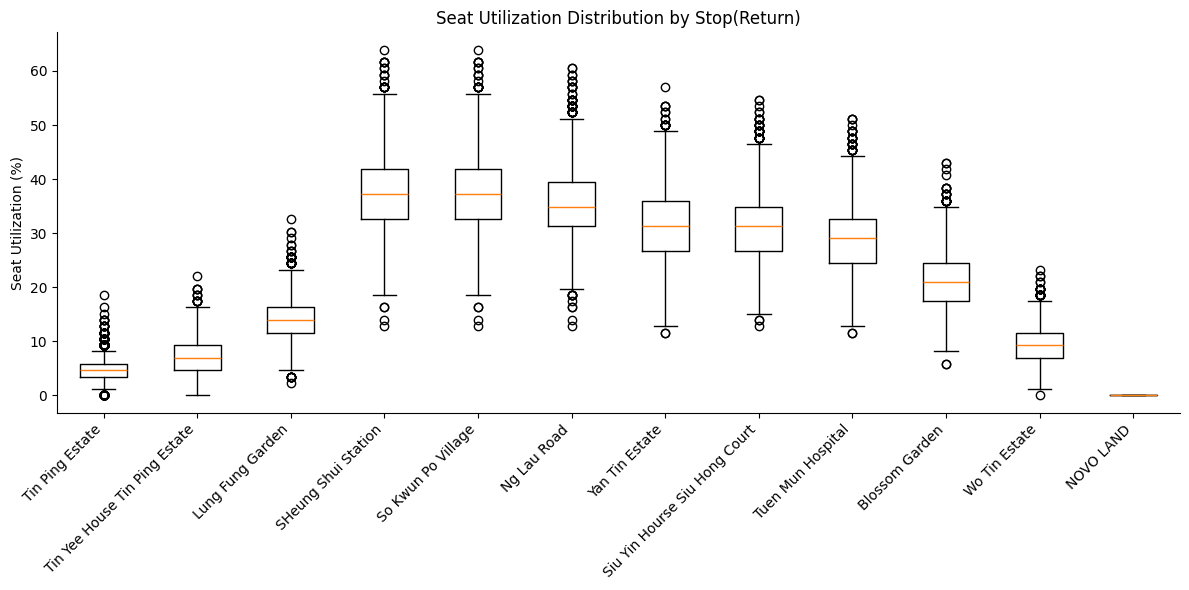

In [ ]:
from typing import ForwardRef
import matplotlib.pyplot as plt
 # Create box plot for utilization by stop
plt.figure(figsize=(12, 6))
# Prepare data for box plot
utilization_data = []
labels = []
df=df1
forward_stop_names = {
        1: 'Ching Tin Estate',
        2: 'NOVA LAND',
        3: 'Wo Tin Estate',
        4: 'Tai Hing Police Station',
        5: 'Kei Lun Wai',
        6: 'Yan Tin Estate',
        7: 'Ng Lau Road',
        8: 'Sheung Shui Station-Exit D2',
        9: 'San Shing Avenue',
        10: 'Lung Sum Avenue Sports Center',
        11: 'Tin Ping Estate'}

backward_stop_names = {
        1: 'Tin Ping Estate',
        2: 'Tin Yee House Tin Ping Estate',
        3: 'Lung Fung Garden',
        4: 'SHeung Shui Station',
        5: 'So Kwun Po Village',
        6: 'Ng Lau Road',
        7: 'Yan Tin Estate',
        8: 'Siu Yin Hourse Siu Hong Court',
        9: 'Tuen Mun Hospital',
        10: 'Blossom Garden',
        11: 'Wo Tin Estate',
        12: 'NOVO LAND'}

for direction in ['backward']:
    direction_df = df[df['direction'] == direction]
    stops = sorted(direction_df['stop'].unique())
    custom_stop_names= backward_stop_names

    for stop in stops:
        stop_data = direction_df[direction_df['stop'] == stop]['utilization'] * 100
        utilization_data.append(stop_data)
        labels.append(f"{custom_stop_names.get(stop, f'未知站点 {stop}')}")

plt.boxplot(utilization_data, labels=labels)
plt.title('Seat Utilization Distribution by Stop(Return)')

plt.ylabel('Seat Utilization (%)')
plt.xticks(rotation=45, ha='right')



ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

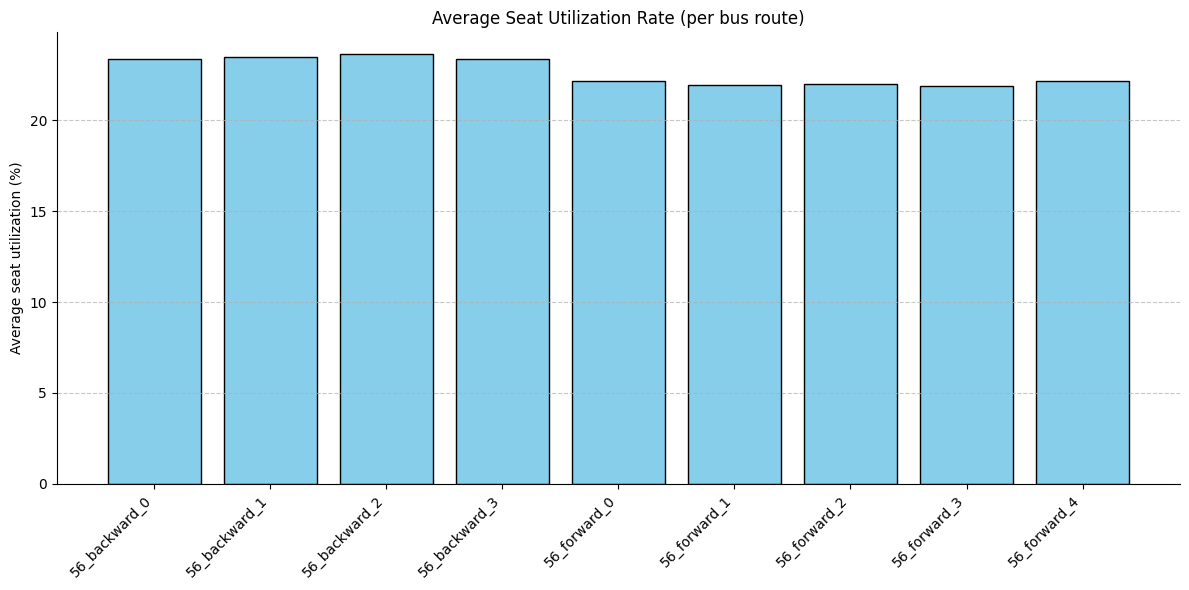

In [ ]:
import matplotlib.pyplot as plt
df_filtered = df1[~(
       ((df1['direction'] == 'forward') & (df1['stop'] == 11)) |
       ((df1['direction'] == 'backward') & (df1['stop'] == 12))
   )]

# 按 bus_id 和 direction 分组，计算平均座位利用率
avg_util = df_filtered.groupby(['bus_id'])['utilization'].mean() * 100

# 创建横坐标标签，例如 "bus_forward_1", "bus_forward_2", "bus_backward"
labels = [f"{bus_id}" for bus_id in avg_util.index]

# 提取平均利用率数据
utilization_values = avg_util.values

# 绘制柱状图
plt.figure(figsize=(12, 6))
plt.bar(labels, utilization_values, color='skyblue', edgecolor='black')
plt.title('Average Seat Utilization Rate (per bus route)')
plt.ylabel('Average seat utilization (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

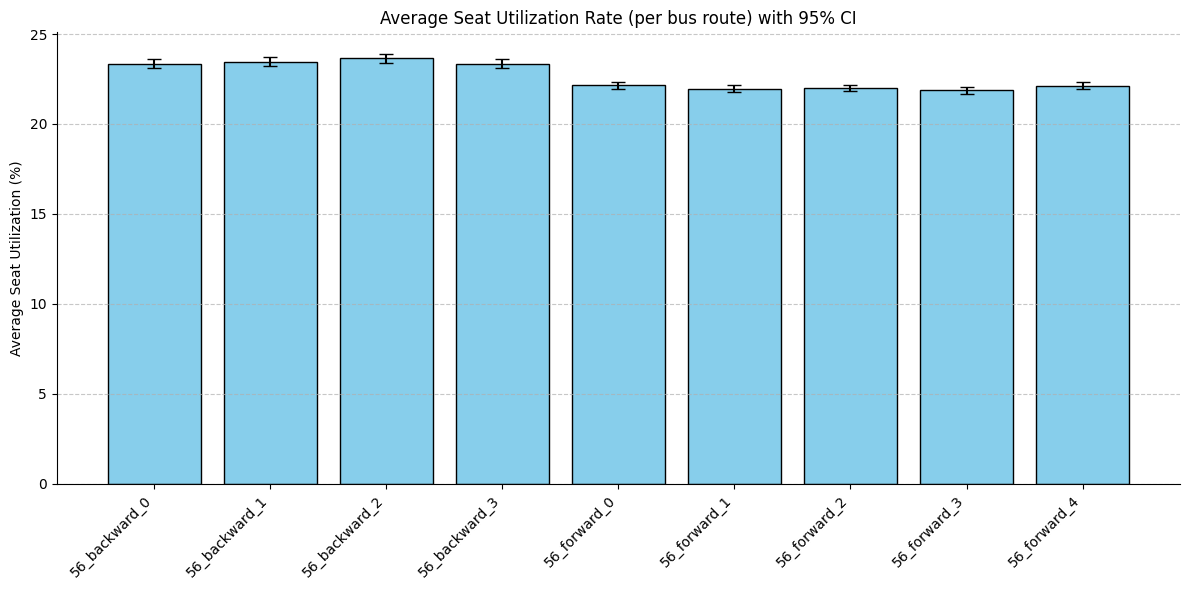

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df_filtered = df1[~(
       ((df1['direction'] == 'forward') & (df1['stop'] == 11)) |
       ((df1['direction'] == 'backward') & (df1['stop'] == 12))
   )]

# 按 bus_id 分组，计算平均座位利用率和标准误差
grouped = df_filtered.groupby('bus_id')['utilization']
avg_util = grouped.mean() * 100  # 转换为百分比
std_util = grouped.std() * 100   # 标准差
n = grouped.count()              # 样本量
# 计算标准误差
se_util = std_util / np.sqrt(n)
# 计算95%置信区间的误差范围（使用t分布）
ci_95 = se_util * stats.t.ppf(0.975, n - 1)  # 95%置信区间

labels = [f"{bus_id}" for bus_id in avg_util.index]
utilization_values = avg_util.values
error_values = ci_95.values  # 误差线长度

# 绘制柱状图并添加误差线
plt.figure(figsize=(12, 6))
plt.bar(labels, utilization_values, yerr=error_values, capsize=5, color='skyblue', edgecolor='black')
plt.title('Average Seat Utilization Rate (per bus route) with 95% CI')
plt.ylabel('Average Seat Utilization (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# 56路线修改前

In [ ]:
import simpy
import numpy as np
import pandas as pd
from collections import deque

BUS_CAPACITY = 86
BUS_SPEED = 50  # km/h
NUM_SIMULATIONS = 1000  # Number of simulations to run
headway = 30 #发车间隔

# Route 56: Tuen Mun to Sheung Shui (11 stops, 10 segments)
route_56_forward = {
    'stops': 11,
    'segment_distances': [0.25, 0.5, 0.22, 0.5, 0.45, 0.75, 23.3, 0.55, 0.158, 0.46],  # km
    'segment_times_params': [  # 每个路段的均值、标准差、最小值、最大值
        {'mean': 1, 'std': 0.83, 'min': 0, 'max': 1},   #路段1
        {'mean': 2, 'std': 0.83, 'min': 2, 'max': 3},   # 路段2
        {'mean': 1, 'std': 0, 'min': 1, 'max': 1},    # 路段3
        {'mean': 1.0, 'std': 0.2, 'min': 1, 'max': 2},    # 路段4
        {'mean': 2, 'std': 0.3, 'min': 1, 'max': 3},    # 路段5
        {'mean': 2.0, 'std': 0.63, 'min': 1, 'max': 3},    # 路段6
        {'mean': 24, 'std': 1.0, 'min': 22, 'max': 29},   # 路段7
        {'mean': 3.667, 'std': 0.516, 'min': 3, 'max': 5},    # 路段8
        {'mean': 2.167, 'std': 0.753, 'min': 1, 'max': 3},    # 路段9
        {'mean': 2.167, 'std': 0.5, 'min': 1, 'max': 4}],   # 路段10
    'stop_lambdas': [0.5, 0, 0.2, 0.25, 0.45, 0.2, 0, 0.3, 0, 0, 0],  # passengers/min per stop第3，4个站点变
    'alight_probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.68, 0.15, 0.15, 1.0],
    'departures': [555, 585, 615]  # 9:10, 9:30, 9:50, 10:10, 10:30 (mins from midnight)
}
# Route 56: Sheung Shui to Tuen Mun (12 stops, 11 segments)
route_56_backward = {
    'stops': 10,
    'segment_distances': [0.4, 0.3, 0.3, 0.8, 22.4, 0.6, 0.9, 0.3, 0.55],  # km
    'segment_times_params': [  # 每个路段的均值、标准差、最小值、最大值
        {'mean': 1.714, 'std': 0.448, 'min': 1, 'max': 3},   # 路段1
        {'mean': 2.143, 'std': 0.69, 'min': 1, 'max': 4},    # 路段2
        {'mean': 2.0, 'std': 0.617, 'min': 1, 'max': 4},    # 路段3
        {'mean': 4.286, 'std': 0.756, 'min': 3, 'max': 6},    # 路段4
        {'mean': 24.714, 'std': 1.112, 'min': 23, 'max': 28}, # 路段5
        {'mean': 1.0, 'std': 0.0, 'min': 1, 'max': 1},    # 路段6（固定）
        {'mean': 3.5, 'std': 0.5, 'min': 3, 'max': 5},   # 路段7
        {'mean': 1, 'std': 0, 'min': 1, 'max': 1},    # 路段8（固定）
        {'mean': 2.5, 'std': 0.5, 'min': 2, 'max': 3}],    # 路段9
    'stop_lambdas': [0.2, 0.1, 0.3, 1, 0, 0, 0.05, 0, 0, 0],  # passengers/min per stop
    'alight_probabilities': [0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.15, 0.3, 0.6, 1.0],
    'departures': [570, 600, 630]

}
def initialize_globals():
    """Initialize global variables for simulation."""
    global utilization_56, stop_queues, last_service_times
    utilization_56 = deque()
    stop_queues = {
        f"{direction}_{stop}": {'count': 0, 'arrivals': []}
        for direction in ['forward', 'backward']
        for stop in range(1, max(route_56_forward['stops'], route_56_backward['stops']) + 1)
    }
    last_service_times = {
        f"{direction}_{stop}": 0  # 初始时间设为 0，稍后在 bus_trip 中调整
        for direction in ['forward', 'backward']
        for stop in range(1, max(route_56_forward['stops'], route_56_backward['stops']) + 1)
    }

def bus_trip(env, bus_id, headway, forward=True, start_time=0):
    """Simulate a single bus trip with queue-based passenger accumulation and wait time tracking."""
    route_data = route_56_forward if forward else route_56_backward
    stops = route_data['stops']
    segment_distances = route_data['segment_distances']

    # segment_time
    segment_times=[]
    for param in route_data['segment_times_params']:
      if param['std'] == 0:
        segment_times.append(param['mean'])
      else:
        # 生成正态分布随机数，四舍五入并限制到范围
        value=round(np.random.normal(param['mean'], param['std']))
        value=max(param['min'],min(param['max'],value))
        segment_times.append(value)

    stop_lambdas = route_data['stop_lambdas']
    alight_probabilities = route_data['alight_probabilities']

    # 使用 env.timeout 等待直到发车时间（start_time）。如果当前仿真时间（env.now）已经超过发车时间，则立即开始
    yield env.timeout(max(0, start_time - env.now))

    # Current passengers on bus
    passengers = 0

    for stop in range(1, stops + 1):
        stop_key = f"{'forward' if forward else 'backward'}_{stop}"
        # 计算 time_interval
        if stop == 1:
          time_interval = headway  # 首站使用 headway
        else:
          # 对于第一班车，非首站 time_interval
          if stop_key not in last_service_times or last_service_times[stop_key] == 0:
              time_interval = headway  # 第一班车非首站
          else:
              time_interval = env.now - last_service_times[stop_key]  # 其他情况使用到达间隔
              if time_interval <= 0:
                raise ValueError(f"Negative time_interval at stop {stop_key}: {time_interval}")

        # 更新 last_service_times
        last_service_times[stop_key] = env.now

        # Alighting
        if stop == stops:
          alighting = passengers
        else:
          prob_alight = alight_probabilities[stop - 1]
          # Each passenger decides to alight based on probability
          alighting = np.random.binomial(passengers, prob_alight)
        passengers -= alighting

        # Boarding
        # time_interval: 计算乘客累积的时间间隔
        lambda_rate = stop_lambdas[stop - 1]
        # 新到站的乘客数量
        new_arrivals = np.random.poisson(lambda_rate * time_interval)
        # 为每个新到达的乘客生成随机到达时间
        arrival_times = np.random.uniform(low=env.now - time_interval, high=env.now, size=new_arrivals)
        # 记录新乘客的到站时间
        stop_queues[stop_key]['arrivals'].extend(arrival_times)
        # 站点排队人数
        arrivals = stop_queues[stop_key]['count'] + new_arrivals
        # 计算实际能上车的乘客数
        boarding = min(arrivals, BUS_CAPACITY - passengers)
        # 计算上车乘客的等待时间（当前时间 env.now 减去每个乘客的到达时间）
        wait_times = [round(env.now - t) for t in stop_queues[stop_key]['arrivals'][:boarding]]

        # Update queue
          # 移除已上车的乘客（保留剩余的 arrivals[boarding:]）
          # 更新排队乘客数（arrivals - boarding）
        stop_queues[stop_key]['arrivals'] = stop_queues[stop_key]['arrivals'][boarding:]
        stop_queues[stop_key]['count'] = arrivals - boarding
        # 更新车上乘客数，增加上车人数
        passengers += boarding

        # Record utilization with bus_id, stop, time, and wait times
        util = passengers / BUS_CAPACITY
        utilization_56.append({
            'bus_id': bus_id,
            'stop': stop,
            'direction': 'forward' if forward else 'backward',
            'utilization': util,
            'time': env.now,
            # 站点剩余排队乘客数
            'queued_passengers': stop_queues[stop_key]['count'],
            'boarding':boarding,
            'alighting':alighting,
            # 上车乘客的等待时间列表
            'wait_times': wait_times
        })

        # 如果不是最后一个站点，等待行驶时间（segment_times[stop - 1]）到下一站
        if stop < stops:
            yield env.timeout(segment_times[stop - 1])

# 运行一次仿真
def run_simulation():
    """Run a single simulation and return utilization data."""
    initialize_globals()  # Reset global variables
    env = simpy.Environment()

    # 计算 headway
    forward_departures = route_56_forward['departures']
    backward_departures = route_56_backward['departures']

    # Schedule forward trips
    for i, dep_time in enumerate(route_56_forward['departures']):
        bus_id = f"56_forward_{i}"
        env.process(bus_trip(env, bus_id, headway, forward=True, start_time=dep_time))

    # Schedule backward trips
    for i, dep_time in enumerate(route_56_backward['departures']):
        bus_id = f"56_backward_{i}"
        env.process(bus_trip(env, bus_id, headway, forward=False, start_time=dep_time))

    # Calculate maximum trip time for simulation duration
    max_backward_times = [param['max'] for param in route_56_backward['segment_times_params']]
    max_forward_times = [param['max'] for param in route_56_forward['segment_times_params']]
    max_trip_time = max(
        sum(max_forward_times),
        sum(max_backward_times)
    )
    latest_departure = max(route_56_forward['departures'] + route_56_backward['departures'])
    # 运行仿真直到最晚发车时间加上最长行程时间。
    simulation_duration = latest_departure + max_trip_time
    env.run(until = simulation_duration)

    return list(utilization_56)


df=run_simulation()


In [ ]:
# 运行多次仿真并分析结果
def run_multiple_simulations():
    """Run simulation multiple times and compute average results."""
    # 存储所有仿真的数据
    all_data = []

    for sim in range(NUM_SIMULATIONS):
        np.random.seed(42 + sim)  # Different seed for each simulation
        data = run_simulation()
        # 为每条记录添加仿真编号（simulation）
        for record in data:
            record['simulation'] = sim
        all_data.extend(data)

    if all_data:
        df = pd.DataFrame(all_data)
        # 计算每辆公交车在每次仿真中的平均利用率，删除最后一站的数据
        df_filter = df[~(
            ((df['direction'] == 'forward') & (df['stop'] == 11)) |
            ((df['direction'] == 'backward') & (df['stop'] == 10)))]
        avg_util = df_filter.groupby(['bus_id', 'direction'])['utilization'].agg(['mean','std','max']) * 100
        print("\nAverage Utilization by Bus (over 1000 simulations):")
        for index, row in avg_util.iterrows():
          bus_id, direction = index
          print(f"Bus {bus_id} ({direction}): Average Utilization: {row['mean']:.2f}% std Utilization:{row['std']:.2f}% max Utilization: {row['max']:.2f}%")

        # 计算每个站点在每次仿真中的平均利用率和排队乘客数（先按 direction、stop 和 simulation 分组取均值，再按 direction 和 stop 取均值）
        stop_stats = df.groupby(['direction', 'stop']).agg({
            'utilization': ['mean','std','max'],
            'queued_passengers': 'mean'
        })

        # 计算每个站点的平均和最大等待时间

        wait_dist = df.explode('wait_times').groupby(['direction', 'stop'])['wait_times'].agg(['mean', 'max'])

        print("\nAverage Utilization, Queued Passengers, and Wait Times by Stop (over 1000 simulations):")
        for (direction, stop), row in stop_stats.iterrows():
          wait_row = wait_dist.loc[(direction, stop)]
          print(f"{direction} Stop {stop}:\n Utilization mean: {row['utilization']['mean'] * 100:.2f}% "
            f"std: {row['utilization']['std'] * 100:.2f}%  "
            f"max: {row['utilization']['max'] * 100:.2f}%\n"
            f"Queued Passengers: {row['queued_passengers']['mean']:.2f}\n "
            f"Mean Wait: {wait_row['mean']:.2f} minutes, Max Wait: {wait_row['max']:.2f} minutes\n")

        # Overall utilization
        df_over = df[~(
            ((df['direction'] == 'forward') & (df['stop'] == 11)) |
            ((df['direction'] == 'backward') & (df['stop'] == 10)))]
        overall_avg = df_over['utilization'].mean() * 100
        print(f"\nRoute 56 Overall Utilization (over 1000 simulations): {overall_avg:.2f}%")
        return df
    else:
        print("No utilization data collected.")

df2=run_multiple_simulations()


Average Utilization by Bus (over 1000 simulations):
Bus 56_backward_0 (backward): Average Utilization: 33.21% std Utilization:20.43% max Utilization: 89.53%
Bus 56_backward_1 (backward): Average Utilization: 32.82% std Utilization:20.25% max Utilization: 81.40%
Bus 56_backward_2 (backward): Average Utilization: 33.26% std Utilization:20.59% max Utilization: 83.72%
Bus 56_forward_0 (forward): Average Utilization: 31.89% std Utilization:15.28% max Utilization: 79.07%
Bus 56_forward_1 (forward): Average Utilization: 31.91% std Utilization:15.26% max Utilization: 86.05%
Bus 56_forward_2 (forward): Average Utilization: 31.96% std Utilization:15.29% max Utilization: 81.40%

Average Utilization, Queued Passengers, and Wait Times by Stop (over 1000 simulations):
backward Stop 1:
 Utilization mean: 6.94% std: 2.79%  max: 17.44%
Queued Passengers: 0.00
 Mean Wait: 15.06 minutes, Max Wait: 30.00 minutes

backward Stop 2:
 Utilization mean: 10.45% std: 3.45%  max: 23.26%
Queued Passengers: 0.00
 

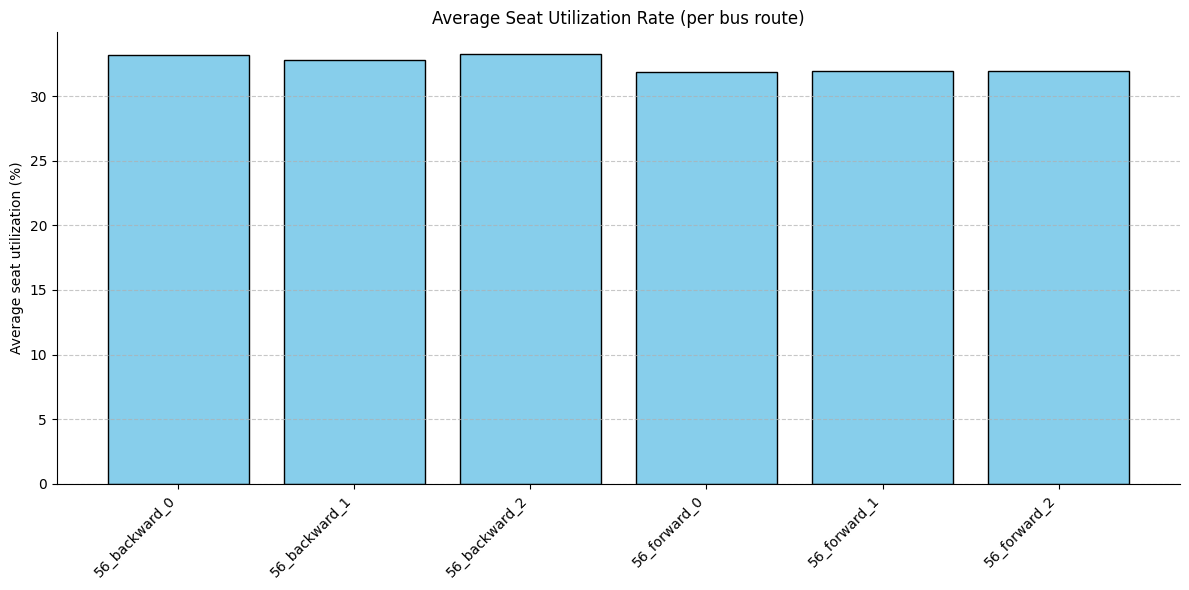

In [ ]:
import matplotlib.pyplot as plt
df_filtered = df[~(
       ((df['direction'] == 'forward') & (df['stop'] == 11)) |
       ((df['direction'] == 'backward') & (df['stop'] == 10))
   )]

# 按 bus_id 和 direction 分组，计算平均座位利用率
avg_util = df_filtered.groupby(['bus_id'])['utilization'].mean() * 100

# 创建横坐标标签，例如 "bus_forward_1", "bus_forward_2", "bus_backward"
labels = [f"{bus_id}" for bus_id in avg_util.index]

# 提取平均利用率数据
utilization_values = avg_util.values

# 绘制柱状图
plt.figure(figsize=(12, 6))
plt.bar(labels, utilization_values, color='skyblue', edgecolor='black')
plt.title('Average Seat Utilization Rate (per bus route)')
plt.ylabel('Average seat utilization (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

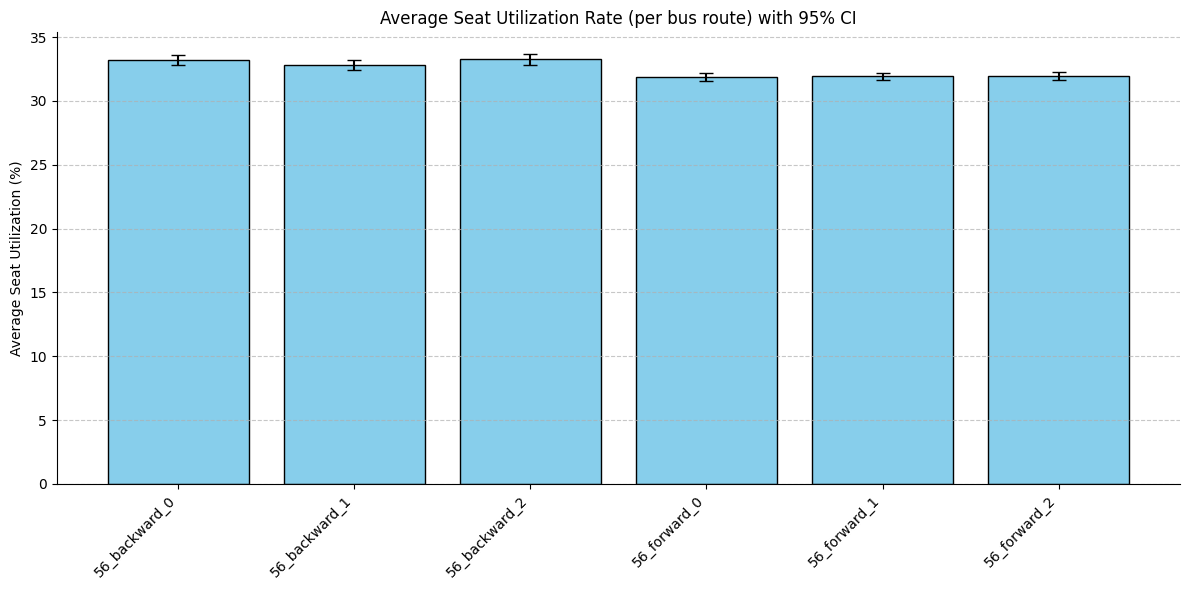

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

df_filtered = df2[~(
       ((df2['direction'] == 'forward') & (df2['stop'] == 11)) |
       ((df2['direction'] == 'backward') & (df2['stop'] == 10))
   )]

# 按 bus_id 分组，计算平均座位利用率和标准误差
grouped = df_filtered.groupby('bus_id')['utilization']
avg_util = grouped.mean() * 100  # 转换为百分比
std_util = grouped.std() * 100   # 标准差
n = grouped.count()              # 样本量
# 计算标准误差
se_util = std_util / np.sqrt(n)
# 计算95%置信区间的误差范围（使用t分布）
ci_95 = se_util * stats.t.ppf(0.975, n - 1)  # 95%置信区间

labels = [f"{bus_id}" for bus_id in avg_util.index]
utilization_values = avg_util.values
error_values = ci_95.values  # 误差线长度

# 绘制柱状图并添加误差线
plt.figure(figsize=(12, 6))
plt.bar(labels, utilization_values, yerr=error_values, capsize=5, color='skyblue', edgecolor='black')
plt.title('Average Seat Utilization Rate (per bus route) with 95% CI')
plt.ylabel('Average Seat Utilization (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

/tmp/ipython-input-33-1918466501.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2_filtered = filter_df(df2)[df2['direction'] == 'forward']


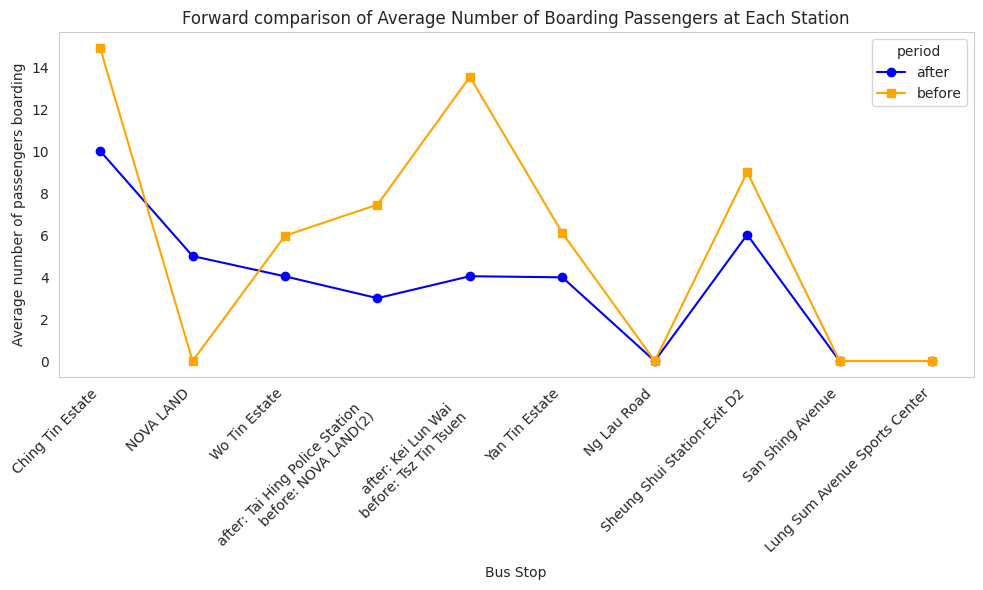

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

def filter_df(df):
    return df[~(
        ((df['direction'] == 'forward') & (df['stop'] == 11)) |
        ((df['direction'] == 'backward') & (df['stop'] == 12))
    )]

# 筛选指定方向的数据
df1_filtered = filter_df(df1)[df1['direction'] == 'forward']
df2_filtered = filter_df(df2)[df2['direction'] == 'forward']

forward_stop_names = {
        1: 'Ching Tin Estate',
        2: 'NOVA LAND',
        3: 'Wo Tin Estate',
        4: 'Tai Hing Police Station',
        5: 'Kei Lun Wai',
        6: 'Yan Tin Estate',
        7: 'Ng Lau Road',
        8: 'Sheung Shui Station-Exit D2',
        9: 'San Shing Avenue',
        10: 'Lung Sum Avenue Sports Center',
        11: 'Tin Ping Estate'}

# 按 stop 计算平均上车人数
avg_boarding1 = df1_filtered.groupby('stop')['boarding'].mean().reset_index()
avg_boarding2 = df2_filtered.groupby('stop')['boarding'].mean().reset_index()

# 绘制折线图
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.plot(avg_boarding1['stop'], avg_boarding1['boarding'], marker='o', label='after', color='blue')
plt.plot(avg_boarding2['stop'], avg_boarding2['boarding'], marker='s', label='before', color='orange')

plt.title('Forward comparison of Average Number of Boarding Passengers at Each Station')
plt.xlabel('Bus Stop')
plt.ylabel('Average number of passengers boarding')

stop_ids = sorted(avg_boarding1['stop'].unique())
stop_labels = []
for s in stop_ids:
    label = forward_stop_names.get(s, f'Stop {s}')
    if s == 4:
        label = f"\nafter: Tai Hing Police Station \nbefore: NOVA LAND(2)"
    elif s == 5:
        label = f"\nafter: Kei Lun Wai \nbefore: Tsz Tin Tsuen"
    stop_labels.append(label)


plt.xticks(stop_ids, stop_labels, rotation=45, ha='right')
plt.legend(title='period')
plt.tight_layout()
plt.grid(False)
plt.show()

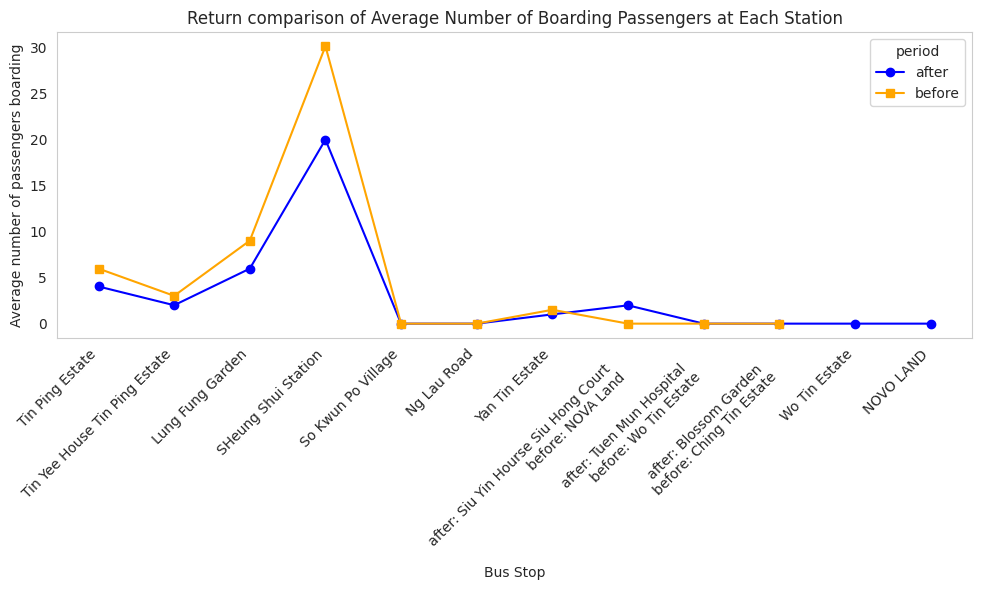

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn

def filter_df(df):
    return df[~(
        ((df['direction'] == 'forward') & (df['stop'] == 11)) |
        ((df['direction'] == 'backward') & (df['stop'] == 13))
    )]

# 筛选指定方向的数据
df1_filtered = filter_df(df1)[df1['direction'] == 'backward']
df2_filtered = filter_df(df2)[df2['direction'] == 'backward']

backward_stop_names = {
        1: 'Tin Ping Estate',
        2: 'Tin Yee House Tin Ping Estate',
        3: 'Lung Fung Garden',
        4: 'SHeung Shui Station',
        5: 'So Kwun Po Village',
        6: 'Ng Lau Road',
        7: 'Yan Tin Estate',
        8: 'Siu Yin Hourse Siu Hong Court',
        9: 'Tuen Mun Hospital',
        10: 'Blossom Garden',
        11: 'Wo Tin Estate',
        12: 'NOVO LAND'}

# 按 stop 计算平均上车人数
avg_boarding1 = df1_filtered.groupby('stop')['boarding'].mean().reset_index()
avg_boarding2 = df2_filtered.groupby('stop')['boarding'].mean().reset_index()

# 绘制折线图
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.plot(avg_boarding1['stop'], avg_boarding1['boarding'], marker='o', label='after', color='blue')
plt.plot(avg_boarding2['stop'], avg_boarding2['boarding'], marker='s', label='before', color='orange')

plt.title('Return comparison of Average Number of Boarding Passengers at Each Station')
plt.xlabel('Bus Stop')
plt.ylabel('Average number of passengers boarding')

stop_ids = sorted(avg_boarding1['stop'].unique())
stop_labels = []
for s in stop_ids:
    label = backward_stop_names.get(s, f'Stop {s}')
    if s == 8:
        label = f"\nafter: {label} \nbefore: NOVA Land"
    elif s == 9:
        label = f"\nafter: {label} \nbefore: Wo Tin Estate"
    elif s ==10:
        label = f"\nafter: {label} \nbefore: Ching Tin Estate"
    stop_labels.append(label)


plt.xticks(stop_ids, stop_labels, rotation=45, ha='right')
plt.legend(title='period')
plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
df1.groupby(['stop','direction'])['boarding'].mean()

stop  direction
1     backward      4.03000
      forward      10.00520
2     backward      1.99700
      forward       4.99840
3     backward      5.96625
      forward       4.03140
4     backward     19.96250
      forward       2.99340
5     backward      0.00000
      forward       4.03840
6     backward      0.00000
      forward       3.98540
7     backward      1.00475
      forward       0.00000
8     backward      1.98475
      forward       6.01660
9     backward      0.00000
      forward       0.00000
10    backward      0.00000
      forward       0.00000
11    backward      0.00000
      forward       0.00000
12    backward      0.00000
Name: boarding, dtype: float64

In [ ]:
import pandas as pd

def add_revenue_column(df, period):
    """Add a revenue column to the DataFrame based on boarded passengers and ticket prices."""
    # 定义票价函数
    def get_ticket_price(row):
        if period == 'after':
            if row['direction'] == 'forward':
                if row['stop'] in range(1, 8):
                    return 16.0
                else:
                    return 4.4
            else:  # direction == 'backward'
                if row['stop'] in range(1, 6):
                    return 16.0
                elif row['stop'] in range(6,11):
                    return 5.6
                else:  # stop 7 and beyond
                    return 5.0
        else:  # period == 'before'
            if row['direction'] == 'forward':
                if row['stop'] in range(1, 8):
                    return 14.6
                else:
                    return 3.9
            else:  # direction == 'backward'
                if row['stop'] in range(1, 7):
                    return 14.6
                elif row['stop'] == 7:
                    return 4.9
                else:  # stop 8 and beyond
                    return 4.4

    # 添加票价列
    df['ticket_price'] = df.apply(get_ticket_price, axis=1)
    # 计算收入金额 = 上车人数 * 票价
    df['revenue'] = df['boarding'] * df['ticket_price']

    return df


df1_with_revenue = add_revenue_column(df1.copy(), 'after')
df2_with_revenue = add_revenue_column(df2.copy(), 'before')

In [ ]:
# 筛选指定方向的数据
import numpy as np
from scipy.stats import norm
import pandas as pd

df2_per_stop= df2_with_revenue.copy()
df1_per_stop= df1_with_revenue.copy()

def ci_format(df,direction):

  df_direction = df[df['direction'] == direction] # Use .copy() to avoid SettingWithCopyWarning

  # 计算每个站点的平均收入、标准差和样本数量
  revenue_stats = df_direction.groupby('stop')['revenue'].agg(['mean', 'std', 'count']).reset_index()

  # 计算标准误
  revenue_stats['se'] = revenue_stats['std'] / np.sqrt(revenue_stats['count'])

  # 计算 95% 置信区间
  # norm.interval(confidence, loc=mean, scale=se)
  revenue_stats['ci_lower'], revenue_stats['ci_upper'] = norm.interval(0.95, loc=revenue_stats['mean'], scale=revenue_stats['se'])

  # 删除不再需要的 std 和 count 列
  revenue_stats = revenue_stats.drop(columns=['std', 'count'])
  return revenue_stats

df2_per_stop_forward = ci_format(df2_per_stop,'forward')
# display(df2_per_stop_forward)
df2_per_stop_backward = ci_format(df2_per_stop,'backward')
# display(df2_per_stop_backward)
df1_per_stop_forward=ci_format(df1_with_revenue,'forward')
display(df1_per_stop_forward)
df1_per_stop_backward=ci_format(df1_with_revenue,'backward')
display(df1_per_stop_backward)




,stop,mean,se,ci_lower,ci_upper
0,1,160.08320,0.719922,158.672179,161.494221
1,2,79.97440,0.510789,78.973271,80.975529
2,3,64.50240,0.454288,63.612011,65.392789
3,4,47.89440,0.397314,47.115679,48.673121
4,5,64.61440,0.464109,63.704764,65.524036
5,6,63.76640,0.453384,62.877783,64.655017
6,7,0.00000,0.000000,NaN,NaN
7,8,26.47304,0.156778,26.165760,26.780320
8,9,0.00000,0.000000,NaN,NaN
9,10,0.00000,0.000000,NaN,NaN


,stop,mean,se,ci_lower,ci_upper
0,1,64.4800,0.504418,63.491358,65.468642
1,2,31.9520,0.362083,31.242330,32.661670
2,3,95.4600,0.619528,94.245747,96.674253
3,4,319.4000,1.192420,317.062900,321.737100
4,5,0.0000,0.000000,NaN,NaN
5,6,0.0000,0.000000,NaN,NaN
6,7,5.6266,0.089073,5.452021,5.801179
7,8,11.1146,0.123581,10.872385,11.356815
8,9,0.0000,0.000000,NaN,NaN
9,10,0.0000,0.000000,NaN,NaN


In [ ]:
# 计算该方向的平均总收入（每轮仿真的总收入平均值）
import numpy as np
from scipy.stats import norm
import pandas as pd

df2_per_stop= df2_with_revenue.copy()
df1_per_stop= df1_with_revenue.copy()

def total_ci(df,direction):


  df=df[df['direction']==direction]
  total_revenue_per_simulation = df.groupby('simulation')['revenue'].sum()
  # 计算每个站点的平均收入、标准差和样本数量
  revenue_mean = total_revenue_per_simulation.mean()
  revenue_std = total_revenue_per_simulation.std(ddof=1)
  revenue_count = total_revenue_per_simulation.count()

  # 计算标准误
  revenue_se = revenue_std / np.sqrt(revenue_count)

  # 计算 95% 置信区间

  ci_lower, ci_upper = norm.interval(0.95, loc=revenue_mean, scale=revenue_se)


  return pd.Series({
      'mean': revenue_mean,
      'se': revenue_se,
      'ci_lower': ci_lower,
      'ci_upper': ci_upper
  })

df2_total_forward = total_ci(df2_per_stop,'forward')
display(df2_total_forward)
df2_total_backward = total_ci(df2_per_stop,'backward')
# display(df2_total_backward)
df1_total_forward = total_ci(df1_per_stop,'forward')
# display(df1_total_forward)
df1_total_backward = total_ci(df1_per_stop,'backward')
# display(df1_total_backward)
a=df1_total_forward-df2_total_forward
b=df1_total_backward-df2_total_backward
c=a+b
display(c-840.58)

,0
mean,2205.699700
se,5.561148
ci_lower,2194.800051
ci_upper,2216.599349


,0
mean,-525.701200
se,-839.377059
ci_lower,-528.058922
ci_upper,-523.343478
